In [16]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/tscc/nfs/home/hsher/Metadensity/config/hg38-tscc2.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
plt.style.use('seaborn-white')
from itertools import chain
from pathlib import Path
import deepdish as dd
import os
import glob

Using /tscc/nfs/home/hsher/gencode_coords/GRCh38.p13.genome.fa


This notebook looks at the relative mean intensity for canonical pas sites that are in the last exon

In [17]:
base_dir = './'

In [18]:
#dd.io.load(os.path.join(base_dir, '{}_prox_passeqSite_200.h5'.format('GRB2')))

In [19]:
import numpy as np
import seaborn as sns
rna = ['LE']
#protein_coding = ['five_prime_UTR', 'first_CDS', 'CDS', 'last_CDS', 'three_prime_UTR']
################## I KNOW THIS IS INELEGANT BUT WE STILL NEED TO SET COLORS #################
color_dict = {
              'LE start': 'hotpink',
              'LE end': 'deeppink'
     }
key_to_name = {'LE': 'LE',
             }

def read_precomputed_array(uid,loc, base_dir = base_dir):
    ''' load deep dish h5 into data structure'''
    return dd.io.load(os.path.join(base_dir, '{}_{}_sample200_length200.h5'.format(uid, loc)))
def get_feature_length(denarray):
    ''' return feature length for each feature in dictionary'''
    features = list(set([d[0] for d in denarray.keys()]))
    feature_len = [denarray[f, 'left', 'rep1'].shape[1] for f in features]
    return dict(zip(features, feature_len))
def merge_two_reps(denarray, features = rna):
    ''' merge two rep, return mean density'''
    all_mean = []
    for f in features:
        for align in ['left', 'right']:

            rep1 = denarray[f, align, 'rep1']
            rep2 = denarray[f, align, 'rep2']

            all_den = np.concatenate([rep1,rep2], axis = 0) # concat into 1 array
            mean = np.nanmean(all_den, axis = 0)
            all_mean.append(mean)
    return(np.concatenate(all_mean))
def into_one_df(uids, l, features = rna):
    ''' given a list of uid, concat all features and data into 1 df'''
    all_vector = []
    i = 0
    for uid in uids:
        denarray = read_precomputed_array(uid, l)
        if i == 0:
            flen = get_feature_length(denarray)
        all_vector.append(merge_two_reps(denarray, features)) # append into results
        i+=1



    df = pd.DataFrame(np.stack(all_vector), index = uids)
    df.fillna(0, inplace = True)
    df.replace(np.nan, 0, inplace = True)

    return df , flen

def get_feat_color(features, flen):
    ''' generate color annotation for heatmap'''
    # get feature length
    colors = []
    names = []
    for f in features:
        length = flen[f]
        name = key_to_name[f]

        for align in ['start', 'end']:
            color_key = '{} {}'.format(name, align)
            names.append(color_key)
            colors += [color_dict[color_key]]*length

    return colors, names


In [20]:
full_list = set([i.split('/')[1].split('_')[0] for i in glob.glob(os.path.join('./','*.h5'))])

In [21]:
remove = [ ]

In [22]:
store_meta = {}
for c in full_list:
    store_meta[c] = {}
    for z in ['LE']:
        df, flen = into_one_df([c],z, rna)
        rna_color, names = get_feat_color(rna, flen)
        store_meta[c][z]=df
        # if strand_dict[c] == "+":  
        #     store_meta[c][z]=df
        # else:
        #     print(c,z)
        #     store_meta[c][z]=pd.DataFrame(df.T[c].tolist()[::-1]).rename(columns={0:c}).T
#     sns.lineplot(x=store_meta[c]['PROXIMAL'].T.index, y=store_meta[c]['PROXIMAL'].T[c], color='purple')
    
#     sns.lineplot(x=store_meta[c]['DISTAL'].T.index, y=store_meta[c]['DISTAL'].T[c], color='lightseagreen')
#     #sns.lineplot(x=store_meta[c]['no'].T.index, y=store_meta[c]['no'].T[c])
#     plt.title(c)
#     plt.axvline(x=200, linestyle='dashed', color='grey')
#     plt.axvline(x=400, color='black')
#     plt.axvline(x=600, linestyle='dashed', color='grey')
#     plt.legend(['PROXIMAL', 'DISTAL'])
#     plt.ylim(0)
#     plt.show()


In [23]:
store_meta = {}
for c in full_list:
    if c not in remove:
        store_meta[c] = {}
        for z in ['LE']:
            df, flen = into_one_df([c],z, rna)
            rna_color, names = get_feat_color(rna, flen)
            store_meta[c][z]=df

In [24]:
feature_info = pd.read_csv('./constitutive_LE_metadensity_features.txt', sep='\t', header=None)

In [25]:
feature_dict = feature_info.groupby(0).apply(lambda r: dict(zip(r[1], r[2]))).to_dict()


In [26]:
feature_dict

{'CPSF6': {'LE': 121},
 'EIF4B': {'LE': 28},
 'GRB2': {'LE': 27},
 'MBNL2': {'LE': 155},
 'NUDT21': {'LE': 129},
 'RBM22': {'LE': 4},
 'RBM5': {'LE': 131},
 'RNPS1': {'LE': 9},
 'STAU2': {'LE': 9},
 'TRNAU1AP': {'LE': 33},
 'ZC3HAV1': {'LE': 148},
 'ZMAT3': {'LE': 25}}

In [27]:
meta_LE_all = pd.DataFrame()
for c in store_meta:
    if c != 'CPSF5':
        if feature_dict[c]['LE'] >= 10:
            meta_LE_all = pd.concat([meta_LE_all,  store_meta[c]['LE'].assign(index_label=c)])
    else:
        if feature_dict['NUDT21']['LE'] >= 10:
            meta_LE_all = pd.concat([meta_LE_all,  store_meta['CPSF5']['LE'].assign(index_label='CPSF5')])
meta_LE_all = meta_LE_all.set_index('index_label')


In [28]:
meta_LE_all.sort_index()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
index_label,,,,,,,,,,,,,,,,,,,,,
CPSF5,0.000209,0.000206,0.000207,0.000204,0.000203,0.000205,0.000203,0.000203,0.000201,0.000197,...,0.000021,0.000019,0.000021,0.000019,0.000019,0.000019,0.000019,0.000019,0.000017,0.000017
CPSF6,-0.000009,-0.000009,-0.000009,-0.000009,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,...,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000003,-0.000003,-0.000003
EIF4B,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,...,-0.000006,-0.000006,-0.000006,-0.000006,-0.000006,-0.000007,-0.000007,-0.000007,-0.000007,-0.000009
GRB2,0.000043,0.000042,0.000043,0.000042,0.000043,0.000042,0.000041,0.000041,0.000038,0.000032,...,0.000056,0.000056,0.000057,0.000061,0.000059,0.000059,0.000059,0.000058,0.000063,0.000053
MBNL2,0.000014,0.000014,0.000014,0.000013,0.000012,0.000013,0.000014,0.000013,0.000013,0.000014,...,-0.000008,-0.000007,-0.000007,-0.000008,-0.000008,-0.000008,-0.000008,-0.000008,-0.000007,-0.000008
RBM5,0.000027,0.000027,0.000027,0.000023,0.000022,0.000020,0.000020,0.000019,0.000017,0.000015,...,0.000008,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007,0.000008
TRNAU1AP,0.000034,0.000033,0.000036,0.000035,0.000037,0.000037,0.000039,0.000038,0.000032,0.000031,...,0.000031,0.000030,0.000030,0.000030,0.000032,0.000028,0.000022,0.000022,0.000022,0.000023
ZC3HAV1,0.000019,0.000019,0.000020,0.000019,0.000018,0.000017,0.000017,0.000019,0.000019,0.000021,...,0.000007,0.000007,0.000007,0.000008,0.000007,0.000007,0.000006,0.000007,0.000007,0.000006
ZMAT3,0.000027,0.000025,0.000023,0.000024,0.000023,0.000024,0.000024,0.000021,0.000019,0.000014,...,0.000017,0.000017,0.000017,0.000017,0.000015,0.000014,0.000015,0.000016,0.000016,0.000017


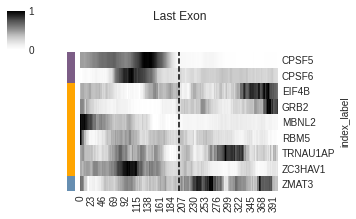

In [41]:
# Your annotation dictionary
screen_results = {
    'CPSF5': 'Upstream',
    'CPSF6': 'Upstream',
    'TRNAU1AP': 'Both',
    'GRB2': 'Both',
    'MBNL2': 'Both',
    'ZC3HAV1': 'Both',
    'RBM5': 'Both',
    'ZMAT3': 'Downstream',
    'RBM22': 'Downstream',
    'EIF4B': 'Both',
    'STAU2': 'Downstream',
    'RNPS1': 'Upstream'
}
# Make into a Series aligned with your dataframe index
annotation = pd.Series(screen_results)

# Choose a colorblind-friendly palette for categories
palette = {
    'Upstream': '#7C5D86',   # purple
    'Downstream': '#668EB1', # blue
    'Both': '#FFA500'        # green
}
# Proximal
row_colors = annotation.map(palette)

g1 = sns.clustermap(
    meta_LE_all.sort_index(), 
    cmap='Greys',
    row_cluster=False, col_cluster=False,
    figsize=(5, 3), 
    standard_scale=0,
    row_colors=row_colors
)
g1.ax_heatmap.axvline(x=200, color='black', linestyle='--')
g1.fig.suptitle('Last Exon')  # title for clustermap

g1.savefig('heatmap_constitutive_LE.png')
g1.savefig('heatmap_constitutive_LE.svg')
g1.savefig('heatmap_constitutive_LE.jpg')